In [13]:
# Import supporting libraries
import pandas 
import numpy
import sklearn.impute as impute
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as modelsel
import sklearn.tree as tree
import sklearn.metrics as metrics
import sklearn.svm as SVC
import pydotplus
import collections
import sklearn
from sklearn.utils import resample
from sklearn.feature_selection import SequentialFeatureSelector
import os
import warnings
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.neural_network import MLPClassifier
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import  ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

In [2]:
# LOAD DATA
filename = 'events.csv'
df = pandas.read_csv(filename)
df = df.drop(['id_odsp', 'id_event', 'sort_order', 'event_type','event_type2','text', 'side', 'event_team', 
              'opponent','player','player2','player_in','player_out'], axis=1)
df

,time,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,2,6.0,2.0,0,9.0,2.0,1,1.0,0
1,4,NaN,NaN,0,NaN,NaN,0,NaN,0
2,4,NaN,NaN,0,NaN,NaN,0,NaN,0
3,7,NaN,NaN,0,NaN,NaN,0,NaN,0
4,7,NaN,NaN,0,2.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...
941004,92,NaN,NaN,0,2.0,NaN,0,NaN,0
941005,93,NaN,NaN,0,NaN,NaN,0,NaN,0
941006,93,8.0,2.0,0,9.0,1.0,1,3.0,0
941007,94,NaN,NaN,0,4.0,NaN,0,NaN,0


In [3]:
#==================: PRE-PROCESS DATA SET :=========================
# Drop nan (Not a number) in the data set. The number of missing observations is
# much larger than the remaining ones, so imputation does not work in this case.
# Since the raw data set is large, we remove the missing values.
df = df.dropna()

# Drop duplicated samples
df = df.drop_duplicates()

In [4]:
# Drop values in shot_place with values 1, 2, 6, 8, 9, and 10 since these vaues imply no goal.

L= [1,2,6,8,9,10]
df = df[~df.shot_place.isin(L)]

# Drop values in shot_outcome with values 2, 3 since these vaues imply no goal.
O= [2,3]
df = df[~df.shot_outcome.isin(O)]

# Export data set after cleaning missing values
df.to_excel('cleaned_dataSPDO.xlsx')

# Check the number of rows in the data set
len_df = len(df.index)
df

,time,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
13,17,4.0,1.0,1,9.0,2.0,1,1.0,0
18,25,7.0,4.0,0,3.0,1.0,1,1.0,0
22,26,5.0,1.0,0,3.0,3.0,2,1.0,0
26,29,5.0,1.0,1,3.0,1.0,1,1.0,0
49,48,11.0,1.0,0,3.0,1.0,1,1.0,0
...,...,...,...,...,...,...,...,...,...
940682,84,5.0,1.0,0,11.0,1.0,4,1.0,0
940722,37,4.0,1.0,1,9.0,1.0,0,1.0,0
940791,21,11.0,1.0,0,12.0,3.0,2,1.0,0
940832,53,7.0,4.0,0,9.0,1.0,0,1.0,0


In [5]:
# Define predictor features and target features for original dataset
X=df.drop(["is_goal"],axis=1)
y=df["is_goal"]

In [6]:
# Count the number of observations (0s and 1s) in the target varible
df_is_goal_1 = df[df["is_goal"]==1]
df_is_goal_0 = df[df["is_goal"]==0]

In [7]:
print(len(df_is_goal_0))
print(len(df_is_goal_1))
print(len(df))

18720
13683
32403


In [8]:
#==============: IMPLEMENT BALANCING TECHNIQUES TO THE DATASET :================
#  Technique 1: Oversampling (technique 2 is combined in the function of training the model)
over_sample_1 = resample(df_is_goal_1,n_samples = len(df_is_goal_0)) 
# The number of observations 0 is bigger than observation 1. 
# So choose len(df_is_goal_0) is 50% of the number of the total observations in the target variable. 
df_oversample = pandas.concat([df_is_goal_0, over_sample_1]) # New data set after oversampling

df_oversample = df_oversample.sample(frac = 1)                          # Sampling without replacement (basically reshuffling data)

# Define predictor features and target features for oversampling dataset
X_oversample =df_oversample.drop(["is_goal"],axis=1)
y_oversample =df_oversample["is_goal"]

Text(0.5, 1.0, 'Before oversampling')

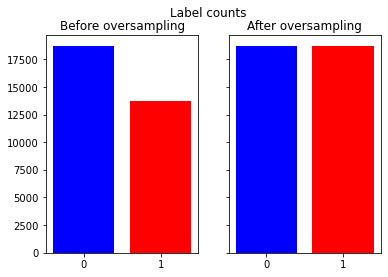

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
fig.suptitle('Label counts')
ax2.bar(x=["0","1"],height=y_oversample.value_counts(),color=["blue","red"])
ax1.bar(x=["0","1"],height=y.value_counts(),color=["blue","red"])

ax2.set_title("After oversampling")
ax1.set_title("Before oversampling")

In [10]:
## Data Normalization: Because feature values are categorical, we don't do data normalization. 

In [11]:
# Define Sequential feature selection method
def feature_sel(model_name, n_selected_features, X, y):  
    #Feature selection
    sfs = SequentialFeatureSelector(model_name, n_features_to_select = n_selected_features)   # Sequential model of sklearn is used
    features= X.columns.values
    sfs.fit(X,y)
    support=sfs.get_support()  
    selected_features=features*support
    selected_features=list(selected_features)
    selected_features=[a for a in selected_features if a!=""]
    print(selected_features)
    return(selected_features)

Before running the model. check the line with model number


1.   1 is random forrest and second digit 1,2,3 are without balancing, oversampling, and with class weights respectively. - Author: Thinh Le
2.   2 is decision tree and second digit 1,2,3 are without balancing, oversampling, and with class weights respectively. - Author: Radhey Krishna
3. 3 is linear SVM and second digit 1,2,3 are without balancing, oversampling, and with class weights respectively. - Author: Sanchit Sethi
4. 4 is MLP and second digit 1,2,3 are without balancing, oversampling, and with class weights respectively. - Author: Yasir Gamieldien


In [ ]:
#Declare the model number here to test the model you wish to test
model=23

In [ ]:
#Author: Thinh Le (Random Forest Classifier all methods)
if model == 11: # This is Random Forest Classifier model without balancing technique
  # Radhey: The optimized parameters can be seen in model == 12, you can use that model to work on player rating
  classifier = sklearn.ensemble.RandomForestClassifier(n_estimators = 2, criterion = 'gini', max_depth = 5, min_samples_leaf = 1)
  selected_features=feature_sel(classifier,3,X,y)
  X_selected=X[selected_features]
  one_hot_X=pd.get_dummies(X_selected,columns=selected_features)
  X_rf=one_hot_X.to_numpy()

  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_rf, y, test_size = 0.3, random_state = RANSEED)

  # Defining possible values of parameters 
  parameters = {'min_samples_leaf': [1, 2], 
                'n_estimators': [100, 300, 500],
                'max_depth': [3, 4, 5],
                'criterion': ['gini', 'entropy']} 
  RFC = sklearn.ensemble.RandomForestClassifier()
  classifier = GridSearchCV(RFC, parameters)
  # Fitting the model 
  classifier.fit(X_train, y_train)
  # print best parameter 
  print(classifier.best_params_)
  # print model
  print(classifier.best_estimator_)
  # Measure model performance
  y_model = classifier.predict(X_test)
  print(classification_report(y_test, y_model)) # print classification report
  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model, normalize = "true"))

In [ ]:
if model == 12: # This is Random Forest Classifier model with oversampling technique
  # Feature selection and onehot encoding for Random Forest Classifier
  
  classifier = sklearn.ensemble.RandomForestClassifier(n_estimators = 2, criterion = 'gini', max_depth = 3, min_samples_leaf = 1)
  selected_features=feature_sel(classifier,3,X_oversample,y_oversample)
  X_selected=X_oversample[selected_features]
  one_hot_X=pd.get_dummies(X_selected,columns=selected_features)
  X_rf=one_hot_X.to_numpy()
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_rf, y_oversample, test_size = 0.3, random_state = RANSEED)

  # Training model
  classifier = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 3, min_samples_leaf = 1) # parameters are set as optimized base model
  classifier.fit(X_train, y_train)
  # Measure model performance
  y_model = classifier.predict(X_test)
  print(classification_report(y_test, y_model)) # print classification report
  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model, normalize = "true"))

In [ ]:
if model == 13: # This is Random Forest Classifier model with class weights technique
  # Feature selection and onehot encoding for Random Forest Classifier
  classifier = sklearn.ensemble.RandomForestClassifier(n_estimators = 2, criterion = 'gini', max_depth = 3, min_samples_leaf = 1)
  selected_features=feature_sel(classifier,3,X,y)
  X_selected=X[selected_features]
  one_hot_X=pd.get_dummies(X_selected,columns=selected_features)
  X_rf=one_hot_X.to_numpy()
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_rf, y, test_size = 0.3, random_state = RANSEED)

  # Training model
  classifier = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 3, min_samples_leaf = 1,class_weight=('balanced'))
  start1 = time.time()
  classifier.fit(X_train, y_train)
  stop1 = time.time()

# Measure model performance

  start2 = time.time()
  y_model = classifier.predict(X_test)
  stop2 = time.time()
  training_time = stop1 - start1
  testing_time = stop2 - start2
  print(classification_report(y_test, y_model)) # print classification report
  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print(training_time)
  print(testing_time)
  cm=sklearn.metrics.confusion_matrix(y_test, y_model,normalize='true')
  print(cm)
  ConfusionMatrixDisplay(cm).plot()

In [ ]:
#Author: Radhey Krishna Adhikari (Decision Tree Classifier all methods)
if model == 21: # This is Decision Tree Classifier model without balancing techniques
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X, y, test_size = 0.3, random_state = RANSEED)

  # Defining possible values of parameters 
  parameters = {'min_samples_leaf': [1, 2], 
                'max_depth': [3, 4, 5],
                'criterion': ['gini', 'entropy']} 
  DTC = tree.DecisionTreeClassifier()
  classifier = GridSearchCV(DTC, parameters)
  # Fitting the model 
  classifier.fit(X_train, y_train)

  # print best parameter 
  print(classifier.best_params_)

  # print model
  print(classifier.best_estimator_)
    
  # Measure model performance
  y_model = classifier.predict(X_test)
  print(classification_report(y_test, y_model)) # print classification report
  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model, normalize = "true"))
  # Recall the chosen classifier to print decision tree
  classifier = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 1)
  classifier.fit(X_train, y_train)
  classifier_predictions = classifier.predict(X_test)

  # Plot decision tree
  featurenames = df.drop(['is_goal'], axis=1).columns.values.tolist()
  classnames = ["0", "1"]

  dot_data = tree.export_graphviz(classifier, out_file=None,feature_names=featurenames,
                              impurity=True, class_names=classnames, filled=True, rounded=True, special_characters=True)
  graph = pydotplus.graph_from_dot_data(dot_data)
  colors = ('lightblue', 'green')
  edges = collections.defaultdict(list)
  for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))
  for edge in edges:
    edges[edge].sort()
  for i in range(2):
      dest = graph.get_node(str(edges[edge][i]))[0]
      dest.set_fillcolor(colors[i])
  filename = "conttree_project.png"
  graph.write_png(filename)
  from IPython.display import Image
  from IPython.core.display import HTML 
  PATH = "conttree_project.png"
  Image(filename = PATH , width=500, height=200)

In [ ]:
if model == 22: # This is Decision Tree Classifier model with oversampling technique
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_oversample, y_oversample, test_size = 0.3, random_state = RANSEED)
  classifier = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 1) # parameters are set as optimized base model

  #Feature Selection: For decision tree classifier, the algorithm naturally choose variables
  # Training model
  classifier.fit(X_train, y_train)

  
  # Measure model performance
  y_model = classifier.predict(X_test)
  print(classification_report(y_test, y_model)) # print classification report
  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model, normalize = "true"))
  # Plot decision tree
  featurenames = df.drop(['is_goal'], axis=1).columns.values.tolist()
  classnames = ["0", "1"]

  dot_data = tree.export_graphviz(classifier, out_file=None,feature_names=featurenames,
                              impurity=True, class_names=classnames, filled=True, rounded=True, special_characters=True)
  graph = pydotplus.graph_from_dot_data(dot_data)
  colors = ('lightblue', 'green')
  edges = collections.defaultdict(list)
  for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))
  for edge in edges:
    edges[edge].sort()
  for i in range(2):
      dest = graph.get_node(str(edges[edge][i]))[0]
      dest.set_fillcolor(colors[i])
  filename = "conttree_project.png"
  graph.write_png(filename)
  from IPython.display import Image
  from IPython.core.display import HTML 
  PATH = "conttree_project.png"
  Image(filename = PATH , width=500, height=200)

              precision    recall  f1-score   support

           0       0.70      0.99      0.82      5604
           1       0.96      0.43      0.59      4117

    accuracy                           0.75      9721
   macro avg       0.83      0.71      0.71      9721
weighted avg       0.81      0.75      0.72      9721

Accuracy score is 0.7505400678942495
Precision is 0.9597826086956521
Recall is 0.42895312120476076
F1 score is 0.5929158972637234
Cross-validation scores is: [0.75050147 0.7484956  0.74170653 0.75       0.74459877]
0.029478073120117188
0.0027391910552978516
[[0.98679515 0.01320485]
 [0.57104688 0.42895312]]


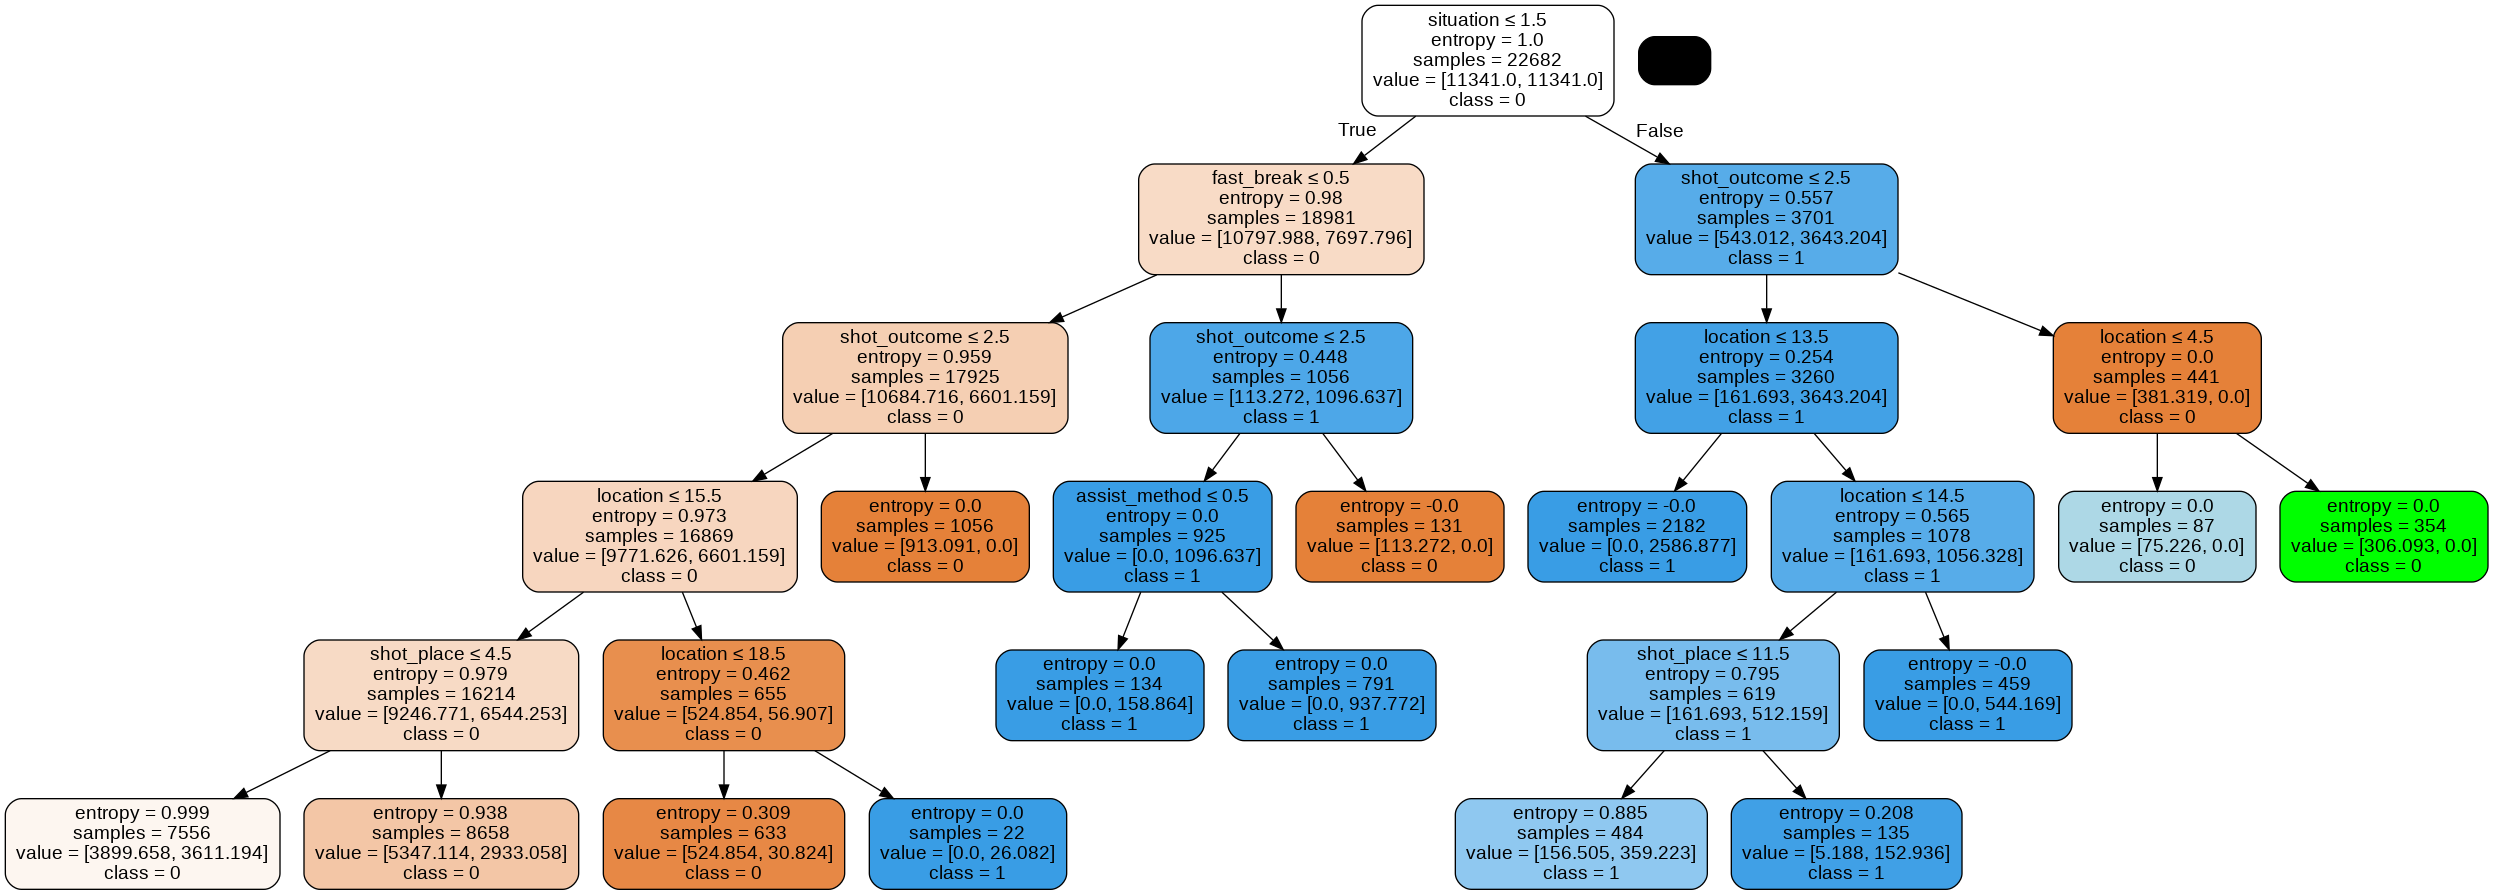

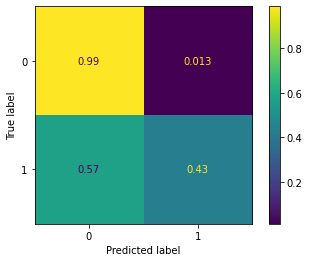

In [ ]:
if model == 23: # This is Decision Tree Classifier model with class weights technique
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X, y, test_size = 0.3, random_state = RANSEED)
  classifier = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 1, class_weight=('balanced')) # parameters are set as optimized base model
  #Feature Selection: For decision tree classifier, the algorithm naturally choose variables

  start1 = time.time()
  classifier.fit(X_train, y_train)
  stop1 = time.time()
# Measure model performance

  start2 = time.time()
  y_model = classifier.predict(X_test)
  stop2 = time.time()
  training_time = stop1 - start1
  testing_time = stop2 - start2

  print(classification_report(y_test, y_model)) # print classification report
  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print(training_time)
  print(testing_time)
  cm=sklearn.metrics.confusion_matrix(y_test, y_model,normalize='true')
  print(cm)
  ConfusionMatrixDisplay(cm).plot()
  # Plot decision tree
featurenames = df.drop(['is_goal'], axis=1).columns.values.tolist()
classnames = ["0", "1"]

dot_data = tree.export_graphviz(classifier, out_file=None,feature_names=featurenames,
                            impurity=True, class_names=classnames, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
colors = ('lightblue', 'green')
edges = collections.defaultdict(list)
for edge in graph.get_edge_list():
  edges[edge.get_source()].append(int(edge.get_destination()))
for edge in edges:
  edges[edge].sort()
for i in range(2):
    dest = graph.get_node(str(edges[edge][i]))[0]
    dest.set_fillcolor(colors[i])
filename = "conttree_project.png"
graph.write_png(filename)
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "conttree_project.png"
Image(filename = PATH , width=500, height=200)

In [ ]:
#Author: Sanchit Sethi (MLP Classifier all methods)
if model == 31: # This is the MLP without balacing techniques
  epochs = 20
# Feature selection and onehot encoding for MLP
  classifier = MLPClassifier(hidden_layer_sizes = (2,2), solver = 'adam', random_state = 24060, activation = 'tanh', \
                    alpha = 0.001, max_iter= 1000)
  selected_features=feature_sel(classifier,3,X,y)
  X_selected=X[selected_features]
  one_hot_X=pd.get_dummies(X_selected,columns=selected_features)
  X_mlp=one_hot_X.to_numpy()
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_mlp, y, test_size = 0.3, random_state = RANSEED)
  # Partition the dataset
  def tfANNModel(): # using the keras API of TensorFlow
    inputwidth = X_train.shape[1]
    tf.random.set_seed(24060)
    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(inputwidth,)),
    tf.keras.layers.Dense(6, activation= 'tanh'),
    tf.keras.layers.Dense(6, activation= 'tanh'),
    tf.keras.layers.Dense(1, activation='relu'),
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
    return model

  model = tfANNModel()
  history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, verbose=0) #This should be fit on the whole X and Y I think
  y_model = model.predict(X_test)
  y_model_bin = 1*(y_model > 0.5)

  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model_bin)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model_bin))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model_bin)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model_bin))) 
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model_bin))
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))

In [ ]:
if model == 32: # This is the MLP with oversampling technique
  epochs = 20
# Feature selection and onehot encoding for MLP
  classifier = MLPClassifier(hidden_layer_sizes = (2,2), solver = 'adam', random_state = 24060, activation = 'tanh', \
                    alpha = 0.001, max_iter= 1000)
  selected_features=feature_sel(classifier,3,X_oversample,y_oversample)
  X_selected=X_oversample[selected_features]
  one_hot_X=pd.get_dummies(X_selected,columns=selected_features)
  X_mlp=one_hot_X.to_numpy()
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_mlp, y_oversample, test_size = 0.3, random_state = RANSEED)
  # Partition the dataset
  
  def tfANNModel(): # using the keras API of TensorFlow
      inputwidth = X_train.shape[1]
      tf.random.set_seed(24060)
      model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(inputwidth,)),
      tf.keras.layers.Dense(6, activation= 'tanh'),
      tf.keras.layers.Dense(6, activation= 'tanh'),
      tf.keras.layers.Dense(1, activation='relu'),
      ])
      model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
      return model

  model = tfANNModel()
  history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, verbose=0) #This should be fit on the whole X and Y I think
  y_model = model.predict(X_test)
  y_model_bin = 1*(y_model > 0.5)

  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model_bin)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model_bin))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model_bin)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model_bin))) 
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model_bin))
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))

In [ ]:
if model == 33: # This is the MLP with class weight technique
  epochs = 20
# Feature selection and onehot encoding for MLP
  classifier = MLPClassifier(hidden_layer_sizes = (2,2), solver = 'adam', random_state = 24060, activation = 'tanh', \
                    alpha = 0.001, max_iter= 1000)
  selected_features=feature_sel(classifier,3,X,y)
  X_selected=X[selected_features]
  one_hot_X=pd.get_dummies(X_selected,columns=selected_features)
  X_mlp=one_hot_X.to_numpy()
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_mlp, y, test_size = 0.3, random_state = RANSEED)
  # Partition the dataset
  
  def tfANNModel(): # using the keras API of TensorFlow
      inputwidth = X_train.shape[1]
      tf.random.set_seed(24060)
      model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(inputwidth,)),
      tf.keras.layers.Dense(6, activation= 'tanh'),
      tf.keras.layers.Dense(6, activation= 'tanh'),
      tf.keras.layers.Dense(1, activation='relu'),
      ])
      model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
      return model

  model = tfANNModel()
  total = len(df_is_goal_1)+len(df_is_goal_0)
  weight_for_0 = (1 / len(df_is_goal_0)) * (total / 2.0)
  weight_for_1 = (1 / len(df_is_goal_1)) * (total / 2.0)

  class_weights = {0: weight_for_0, 1: weight_for_1}

  start1 = time.time()
  history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, verbose=0, class_weight = class_weights)
  stop1 = time.time()

  start2 = time.time()
  y_model = model.predict(X_test)
  stop2 = time.time()
  
  y_model_bin = 1*(y_model > 0.5)
  training_time = stop1 - start1
  prediction_time = stop2 - start2

  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model_bin)))

  print('Precision is {}'.format(metrics.precision_score(y_test, y_model_bin))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model_bin)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model_bin))) 
  cm=sklearn.metrics.confusion_matrix(y_test, y_model_bin,normalize='true')
  print(cm)
  ConfusionMatrixDisplay(cm).plot()
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print("Training time is: ", training_time)
  print("Prediction time is: ", prediction_time)

In [ ]:
#Author: Yasir Gamieldien (SVM classifier all methods)
if model == 41: # This is SVM model without balancing technique
  # Feature selection and onehot encoding for SVM
  # Feature selection takes very long but after the features were found, we manually appended the top 3 features
  classifier = SVC(kernel = "rbf", C=1, gamma = 1)
  #selected_features=feature_sel(classifier,3,X,y)
  X_selected =X_oversample.drop(["time", "shot_outcome", "location", "bodypart","assist_method"],axis=1) #top 3 features selected
  one_hot_X=pd.get_dummies(X_selected,columns=selected_features)
  X_svm=one_hot_X.to_numpy()
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_svm, y, test_size = 0.3, random_state = RANSEED)

  # Training model
  classifier.fit(X_train, y_train)
  #print("SVM Score is %f" % clf.score(X_train, y_train))
  #print("W = ", clf.intercept_, clf.coef_)

  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model, normalize = "true"))

In [ ]:
if model == 42: # This is SVM model with oversampling technique
  # Feature selection and onehot encoding for SVM
  # Feature selection takes very long but after the features were found, we manually appended the top 3 features
  classifier = SVC(kernel = "rbf", C=1, gamma = 1)
  #selected_features=feature_sel(classifier,3,X_oversample,y_oversample)
  X_selected =X_oversample.drop(["time", "shot_outcome", "location", "bodypart","assist_method"],axis=1) #top 3 features selected
  one_hot_X=pd.get_dummies(X_selected)
  X_rf=one_hot_X.to_numpy()
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_rf, y_oversample, test_size = 0.3, random_state = RANSEED)

  # Training model
  classifier = SVC(kernel = "rbf")
  classifier.fit(X_train, y_train)
  # Measure model performance
  y_model = classifier.predict(X_test)
  print(classification_report(y_test, y_model))

  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model, normalize = "true"))

In [ ]:
if model == 43: # This is SVM model with oversampling technique
  # Feature selection and onehot encoding for SVM
  # Feature selection takes very long but after the features were found, we manually appended the top 3 features
  classifier = SVC(kernel = "rbf", class_weight='balanced', C=1, gamma = 1)
  #selected_features=feature_sel(classifier,3,X_oversample,y_oversample)
  X_selected =X.drop(["time", "shot_outcome", "location", "bodypart","assist_method"],axis=1) #top 3 features selected
  one_hot_X=pd.get_dummies(X_selected)
  X_rf=one_hot_X.to_numpy()
  # Partition into training/ test/ validation
  RANSEED = 10000
  X_train, X_test, y_train, y_test = modelsel.train_test_split(X_rf, y, test_size = 0.3, random_state = RANSEED)

  # Training model -
  classifier = SVC(kernel = "rbf")
  start1 = time.time()
  classifier.fit(X_train, y_train)
  stop1 = time.time()
  # Measure model performance
  start2 = time.time()
  y_model = classifier.predict(X_test)
  stop2 = time.time()

  training_time = stop1 - start1
  prediction_time = stop2 - start2

  print(classification_report(y_test, y_model))

  print("Accuracy score is {}".format(metrics.accuracy_score(y_test, y_model)))
  print('Precision is {}'.format(metrics.precision_score(y_test, y_model))) 
  print('Recall is {}'.format(metrics.recall_score(y_test, y_model)))
  print('F1 score is {}'.format(metrics.f1_score(y_test, y_model))) 
  print("Cross-validation scores is:", sklearn.model_selection.cross_val_score(classifier, X, y=y, cv=5))
  print("Confusion matrix is:\n", metrics.confusion_matrix(y_test, y_model, normalize = "true"))

  print("Training time is: ", training_time)
  print("Prediction time time is: ", prediction_time)
  cm=sklearn.metrics.confusion_matrix(y_test, y_model,normalize='true')
  print(cm)

  ConfusionMatrixDisplay(cm).plot()

In [ ]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.634 total time=   5.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.634 total time=   5.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.634 total time=   5.2s


KeyboardInterrupt: ignored

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


AttributeError: ignored

In [ ]:
grid_predictions = grid.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions))

NotFittedError: ignored

In [ ]:
#Run this command to ensure matplot lib is updated to the most recent package to avoid getting error from fig.supylabel and fig.supxlabel
#pip install --upgrade matplotlib

Text(0.5, 0.01, 'Algorithms')

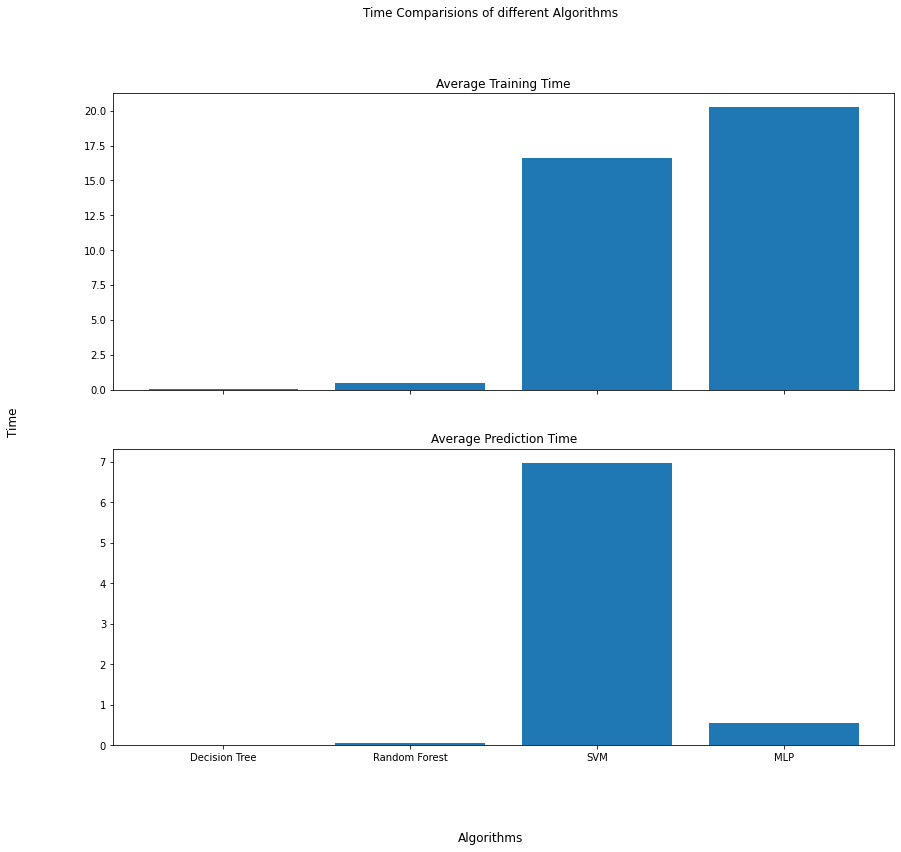

In [ ]:
#Plot for the execution time
#make sure matplotlib is upgraded before running this section might throw an error if not upgraded
#data manually extracted from time.xlsx file
#Author: all team members
y_training=[0.03000,0.466667,16.593333,20.243333]
y_predi=[0.003333,0.066667,6.970000,0.553333]

fig, axs = plt.subplots(2,sharex=True,figsize=(14,12))
fig.suptitle('Time Comparisions of different Algorithms')
axs[0].bar(x=["Decision Tree","Random Forest","SVM","MLP"],
        height=y_training)
axs[1].bar(x=["Decision Tree","Random Forest","SVM","MLP"],
        height=y_predi)

axs[0].set_title("Average Training Time")
axs[1].set_title("Average Prediction Time")


fig.supylabel("Time")
fig.supxlabel("Algorithms")